In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')

# Change the dir_path to your directory
dir_path = "/content/drive/MyDrive/Colab Notebooks/ECE50024/Project/"
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ECE50024/Project/')

Mounted at /content/drive


In [ ]:
# Function for evaluating the performance
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def compare_images(original, compared):
    psnr_val = psnr(original, compared, data_range=compared.max() - compared.min())
    ssim_val, _ = ssim(original, compared, full=True, data_range=compared.max() - compared.min())
    return psnr_val, ssim_val

# Example usage:

# # Normalize images for comparison
# original_normalized = img_array
# noisy_normalized = np.array(noisy_image, dtype=np.float32) / 255.0
# denoised_normalized = np.array(denoised_image, dtype=np.float32) / 255.0

# # Calculate PSNR and SSIM for noisy image
# psnr_noisy, ssim_noisy = compare_images(original_normalized, noisy_normalized)

# # Calculate PSNR and SSIM for denoised image
# psnr_denoised, ssim_denoised = compare_images(original_normalized, denoised_normalized)

# # Print the results
# print(f"Noisy Image PSNR: {psnr_noisy:.2f}, SSIM: {ssim_noisy:.4f}")
# print(f"Denoised Image PSNR: {psnr_denoised:.2f}, SSIM: {ssim_denoised:.4f}")

In [ ]:
# Functions for image -> image np array

def image_to_normalized_array(image):
    """
    Converts a PIL Image object to a normalized (0.0 to 1.0) float32 image array.

    Parameters:
        image (PIL.Image): The input PIL Image object.

    Returns:
        numpy.ndarray: The normalized image array with pixel values between 0.0 and 1.0.
    """
    # Convert the PIL Image to a NumPy array
    img_array = np.asarray(image)

    # Convert the array's data type to float32 for normalization
    img_array = img_array.astype(np.float32)

    # Normalize pixel values to be between 0.0 and 1.0
    img_array /= 255.0

    return img_array

In [ ]:
# Functions for adding noise
import random

def noise_rgb(img, p):
  original_img = img.copy()
  noisy_image = np.zeros(img.shape, np.uint8)
  for i in range(original_img.shape[0]):  # rows
      for j in range(original_img.shape[1]):  # cols
          r = random.random()
          if r < p:
              noisy_image[i][j] = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]
          else:
              noisy_image[i][j] = original_img[i][j]  # original image pixel

  return noisy_image

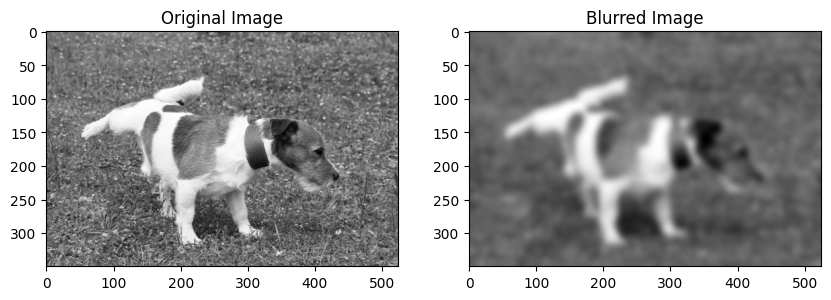

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from PIL import Image
from scipy.ndimage import convolve
from scipy.signal import convolve2d
from skimage.restoration import denoise_tv_chambolle

image = Image.open(dir_path + 'dog_on_grass.jpg')
img_gray = image.convert('L')
img_array = np.array(img_gray, dtype=np.float32) / 255.0  # Normalize the image
# plt.imshow(img_gray, cmap='gray')

M, N = img_array.shape

# Define the blurring kernel, a Gaussian kernel can be used
kernel_size = (50, 50)  # This can be changed
sigma = 5.0
kernel = cv2.getGaussianKernel(kernel_size[0], sigma) * cv2.getGaussianKernel(kernel_size[1], sigma).T

# Blur the image
blurred_image = cv2.filter2D(img_array, -1, kernel)
# plt.imshow(blurred_image, cmap='gray')

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')

plt.show()


Noisy Image PSNR: 18.75, SSIM: 0.4713
Denoised Image PSNR: 23.57, SSIM: 0.6781


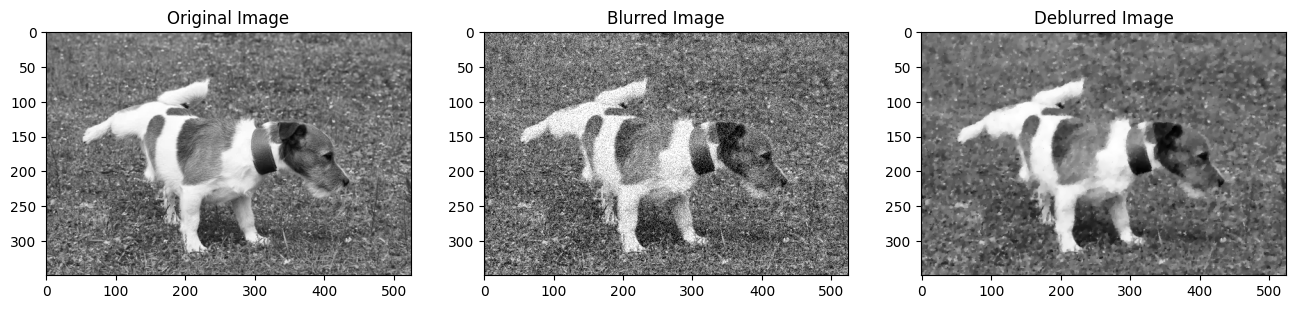

In [ ]:
# Best version

# Plug-and-Play ADMM denoising
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.restoration import denoise_tv_chambolle
import cv2
from PIL import Image
import math

def update_x(x_prev, v_prev, u_prev, rho, f):
    x = (f + rho * (v_prev - u_prev)) / (1 + rho)
    return x

def denoiser(image, sigma):
    return denoise_tv_chambolle(image, weight=sigma)

def update_v(x, u_prev, lambda_val, rho):
    sigma = np.sqrt(lambda_val / rho)
    return denoiser(x + u_prev, sigma)

def update_u(u_prev, x, v):
    return u_prev + (x - v)

def calc_delta(x, x_prev, v, v_prev, u, u_prev):
    delta = np.sqrt(np.mean((x - x_prev)**2) + np.mean((v - v_prev)**2) + np.mean((u - u_prev)**2))
    return delta

def plug_and_play_admm(f, lambda_val, rho_0, eta, gamma, tol, max_iterations):
    x = f.copy()
    v = f.copy()
    u = np.zeros_like(f)

    rho = rho_0
    delta = np.inf
    k = 0

    while delta >= tol and k < max_iterations:
        x_prev = x.copy()
        v_prev = v.copy()
        u_prev = u.copy()

        x = update_x(x_prev, v_prev, u_prev, rho, f)
        v = update_v(x, u_prev, lambda_val, rho)
        u = update_u(u_prev, x, v)

        delta_prev = delta
        delta = calc_delta(x, x_prev, v, v_prev, u, u_prev)

        if delta >= eta * delta_prev:
            rho *= gamma

        k += 1

    return x

def noise_gray(image, noise_level):
  noise = np.random.normal(scale=noise_level, size=image.shape)
  noisy_image = image + noise
  noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
  return noisy_image

image = cv2.imread(dir_path + 'dog_on_grass.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_array = image_to_normalized_array(image_gray)

noisy_image = noise_gray(image_gray, 30)
noisy_array = image_to_normalized_array(noisy_image)

# Example usage:
# f: Blurred image
# lambda_val: Regularization parameter
# rho_0: Initial value of rho
# eta: Convergence criteria parameter
# gamma: Parameter for adjusting rho
# tol: Convergence tolerance
# max_iterations: Maximum number of iterations
# deblurred_image = plug_and_play_admm(f, lambda_val, rho_0, eta, gamma, tol, max_iterations)
denoised_array = plug_and_play_admm(noisy_array, lambda_val=0.001, rho_0=0.00001, eta=0.5, gamma=1.4, tol=0.001, max_iterations=100)


# Calculate PSNR and SSIM for noisy image
psnr_noisy, ssim_noisy = compare_images(img_array, noisy_array)
psnr_denoised, ssim_denoised = compare_images(img_array, denoised_array)
print(f"Noisy Image PSNR: {psnr_noisy:.2f}, SSIM: {ssim_noisy:.4f}")
print(f"Denoised Image PSNR: {psnr_denoised:.2f}, SSIM: {ssim_denoised:.4f}")

# Display the deblurred image
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(noisy_array, cmap='gray')
plt.title('Blurred Image')

plt.subplot(1, 3, 3)
plt.imshow(denoised_array, cmap='gray')
plt.title('Deblurred Image')

plt.show()


0 0.4942449840992771


<ipython-input-9-a19f07ea60cd>:4: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return denoise_tv_chambolle(image, weight=sigma, multichannel=False)


2 0.006062369532203392
4 0.004084464947018735
6 0.002674161945085696
8 0.002098663054403181
10 0.002232277532890397
12 0.0025462036734556145
14 0.002169933774624731
16 0.0015961421247653756
18 0.0010572514037072705
19


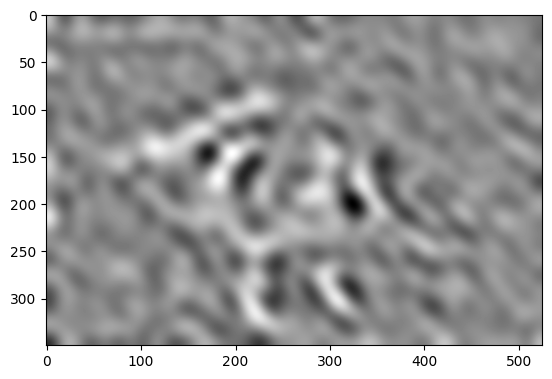

In [ ]:
# My Version

def denoiser(image, sigma):
    return denoise_tv_chambolle(image, weight=sigma, multichannel=False)

def apply_convolution(image, kernel):
    return convolve2d(image, kernel, boundary='wrap', mode='same')

def update_x(x_prev, u_prev, v_prev, rho, kernel):
    A = apply_convolution(x_prev, kernel)
    rhs = np.fft.fftn(A + rho * (v_prev-u_prev))
    x = np.real(np.fft.ifftn(rhs / (np.abs(np.fft.fftn(x_prev))**2 + rho)))
    return x

def update_v(x, u_prev, lambd, rho):
    return denoiser(x + u_prev, np.sqrt(lambd / rho))

def update_u(x, v, u_prev):
    return u_prev + (x - v)

def calc_delta(n, x, x_prev, v, v_prev, u, u_prev):
    return 1/np.sqrt(n) * (np.linalg.norm(x-x_prev) + \
                           np.linalg.norm(v-v_prev) + \
                           np.linalg.norm(u-u_prev))

x_prev = np.zeros_like(blurred_image)
v_prev = v = 0.5*np.zeros_like(blurred_image)
u_prev = u = np.zeros_like(blurred_image)

x = np.array(blurred_image)
iteration = 100
rho = 0.0001
eta = 0.5
lambd = 0.01
gamma = 1.5
tol = 0.001

delta_value = calc_delta(M*N, x, x_prev, v, v_prev, u, u_prev)

k = 0
while delta_value >= tol and k < iteration:
    if k%2==0:
        print(k, delta_value)
    x_prev = x
    v_prev = v
    u_prev = u
    x = update_x(x_prev, u_prev, v_prev, rho, kernel)
    v = update_v(x, u_prev, lambd, rho)
    u = update_u(x, v, u_prev)

    delta_prev = delta_value
    delta_value = calc_delta(M*N, x, x_prev, v, v_prev, u, u_prev)

    if delta_value >= eta*delta_prev:
        rho = gamma*rho
    else:
        rho = rho

    k += 1

print(k)
plt.imshow(v, cmap='gray')


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Load the image
image = cv2.imread(dir_path + 'dog_on_grass.jpg')
# Convert to grayscale instead of RGB
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Convert the image array to float and normalize
img_array = image_to_normalized_array(image_gray)

noisy_image = noise_gray(image_gray, 0.2)

noisy_array = image_to_normalized_array(noisy_image)

# Apply median blur to denoise
denoised_array = cv2.medianBlur(noisy_array, 5)

# Display original, noisy, and denoised images side by side
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(img_array, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(noisy_array, cmap='gray')
plt.title('Noisy Image')

plt.subplot(1, 3, 3)
plt.imshow(denoised_array, cmap='gray')
plt.title('Denoised Image')

plt.show()

# Calculate PSNR and SSIM for noisy image
psnr_noisy, ssim_noisy = compare_images(img_array, noisy_array)

# Calculate PSNR and SSIM for denoised image
psnr_denoised, ssim_denoised = compare_images(img_array, denoised_array)

# Print the results
print(f"Noisy Image PSNR: {psnr_noisy:.2f}, SSIM: {ssim_noisy:.4f}")
print(f"Denoised Image PSNR: {psnr_denoised:.2f}, SSIM: {ssim_denoised:.4f}")

NameError: name 'dir_path' is not defined

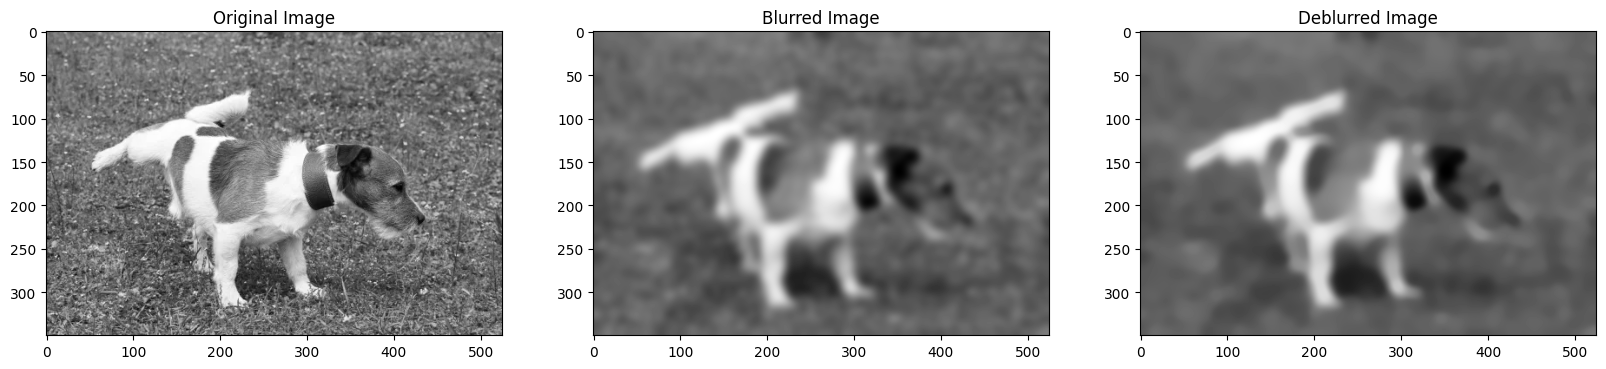

Noisy Image PSNR: 19.53, SSIM: 0.2559
Denoised Image PSNR: 18.82, SSIM: 0.2237


In [ ]:
# Plug-and-Play ADMM deblurring
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.restoration import denoise_tv_chambolle
import cv2
from PIL import Image
import math

def update_x(x_prev, v_prev, u_prev, rho, f):
    x = (f + rho * (v_prev - u_prev)) / (1 + rho)
    return x

def denoiser(image, sigma):
    return denoise_tv_chambolle(image, weight=sigma)

def update_v(x, u_prev, lambda_val, rho):
    sigma = np.sqrt(lambda_val / rho)
    return denoiser(x + u_prev, sigma)

def update_u(u_prev, x, v):
    return u_prev + (x - v)

def calc_delta(x, x_prev, v, v_prev, u, u_prev):
    delta = np.sqrt(np.mean((x - x_prev)**2) + np.mean((v - v_prev)**2) + np.mean((u - u_prev)**2))
    return delta

def plug_and_play_admm(f, lambda_val, rho_0, eta, gamma, tol, max_iterations):
    x = f.copy()
    v = f.copy()
    u = np.zeros_like(f)

    rho = rho_0
    delta = np.inf
    k = 0

    while delta >= tol and k < max_iterations:
        x_prev = x.copy()
        v_prev = v.copy()
        u_prev = u.copy()

        x = update_x(x_prev, v_prev, u_prev, rho, f)
        v = update_v(x, u_prev, lambda_val, rho)
        u = update_u(u_prev, x, v)

        delta_prev = delta
        delta = calc_delta(x, x_prev, v, v_prev, u, u_prev)

        if delta >= eta * delta_prev:
            rho *= gamma

        k += 1

    return x

# Load the image
image = Image.open(dir_path + 'dog_on_grass.jpg')
image_gray = image.convert('L')
# Normalize the image
img_array = np.array(image_gray, dtype=np.float32) / 255.0

# Define the blurring kernel, a Gaussian kernel can be used
kernel_size = (50, 50)
sigma = 5.0
kernel = cv2.getGaussianKernel(kernel_size[0], sigma) * cv2.getGaussianKernel(kernel_size[1], sigma).T

# Blur the image
blurred_image = cv2.filter2D(img_array, -1, kernel)

# Example usage:
# f: Blurred image
# lambda_val: Regularization parameter
# rho_0: Initial value of rho
# eta: Convergence criteria parameter
# gamma: Parameter for adjusting rho
# tol: Convergence tolerance
# max_iterations: Maximum number of iterations
# deblurred_image = plug_and_play_admm(f, lambda_val, rho_0, eta, gamma, tol, max_iterations)
deblurred_image = plug_and_play_admm(blurred_image, lambda_val=0.001, rho_0=0.00001, eta=0.5, gamma=1.5, tol=0.0001, max_iterations=100)

# Display the deblurred image
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')

plt.subplot(1, 3, 3)
plt.imshow(deblurred_image, cmap='gray')
plt.title('Deblurred Image')

plt.show()


# Checkpoint4 Traffic Images

In [ ]:
# Best version

# Plug-and-Play ADMM denoising
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.restoration import denoise_tv_chambolle
import cv2
from PIL import Image
import math
import numpy as np
import cv2
from skimage import img_as_float, img_as_ubyte

def update_x(x_prev, v_prev, u_prev, rho, f):
    x = (f + rho * (v_prev - u_prev)) / (1 + rho)
    return x

def denoiser(image, sigma):
    return denoise_tv_chambolle(image, weight=sigma)

def update_v(x, u_prev, lambda_val, rho):
    sigma = np.sqrt(lambda_val / rho)
    return denoiser(x + u_prev, sigma)

def update_u(u_prev, x, v):
    return u_prev + (x - v)

def calc_delta(x, x_prev, v, v_prev, u, u_prev):
    delta = np.sqrt(np.mean((x - x_prev)**2) + np.mean((v - v_prev)**2) + np.mean((u - u_prev)**2))
    return delta

def plug_and_play_admm(f, lambda_val, rho_0, eta, gamma, tol, max_iterations):
    x = f.copy()
    v = f.copy()
    u = np.zeros_like(f)

    rho = rho_0
    delta = np.inf
    k = 0

    while delta >= tol and k < max_iterations:
        x_prev = x.copy()
        v_prev = v.copy()
        u_prev = u.copy()

        x = update_x(x_prev, v_prev, u_prev, rho, f)
        v = update_v(x, u_prev, lambda_val, rho)
        u = update_u(u_prev, x, v)

        delta_prev = delta
        delta = calc_delta(x, x_prev, v, v_prev, u, u_prev)

        if delta >= eta * delta_prev:
            rho *= gamma

        k += 1

    return x

def noise_gray(image_gray, sigma=0.2):
    # Ensure the image is in floating point format
    image_gray = img_as_float(image_gray)

    # Generate Gaussian noise
    gaussian_noise = np.random.normal(0, sigma, image_gray.shape)

    # Add the Gaussian noise to the image
    noisy_image = image_gray + gaussian_noise

    # Clip the values to stay between 0 and 1 and convert back to an appropriate image format
    noisy_image = np.clip(noisy_image, 0, 1)
    noisy_image = img_as_ubyte(noisy_image)

    return noisy_image

image = cv2.imread("/content/Traffic1.jpg")
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_array = image_to_normalized_array(image_gray)

noisy_image = noise_gray(image_gray, 0.2)
noisy_array = image_to_normalized_array(noisy_image)

# Example usage:
# f: Blurred image
# lambda_val: Regularization parameter
# rho_0: Initial value of rho
# eta: Convergence criteria parameter
# gamma: Parameter for adjusting rho
# tol: Convergence tolerance
# max_iterations: Maximum number of iterations
# deblurred_image = plug_and_play_admm(f, lambda_val, rho_0, eta, gamma, tol, max_iterations)
denoised_array = plug_and_play_admm(noisy_array, lambda_val=0.001, rho_0=0.00001, eta=0.5, gamma=1.4, tol=0.001, max_iterations=100)


# Calculate PSNR and SSIM for noisy image
psnr_noisy, ssim_noisy = compare_images(img_array, noisy_array)
psnr_denoised, ssim_denoised = compare_images(img_array, denoised_array)
print(f"Noisy Image PSNR: {psnr_noisy:.2f}, SSIM: {ssim_noisy:.4f}")
print(f"Denoised Image PSNR: {psnr_denoised:.2f}, SSIM: {ssim_denoised:.4f}")

# Display the deblurred image
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(noisy_array, cmap='gray')
plt.title('Blurred Image')

plt.subplot(1, 3, 3)
plt.imshow(denoised_array, cmap='gray')
plt.title('Deblurred Image')

plt.show()


NameError: name 'img_array' is not defined

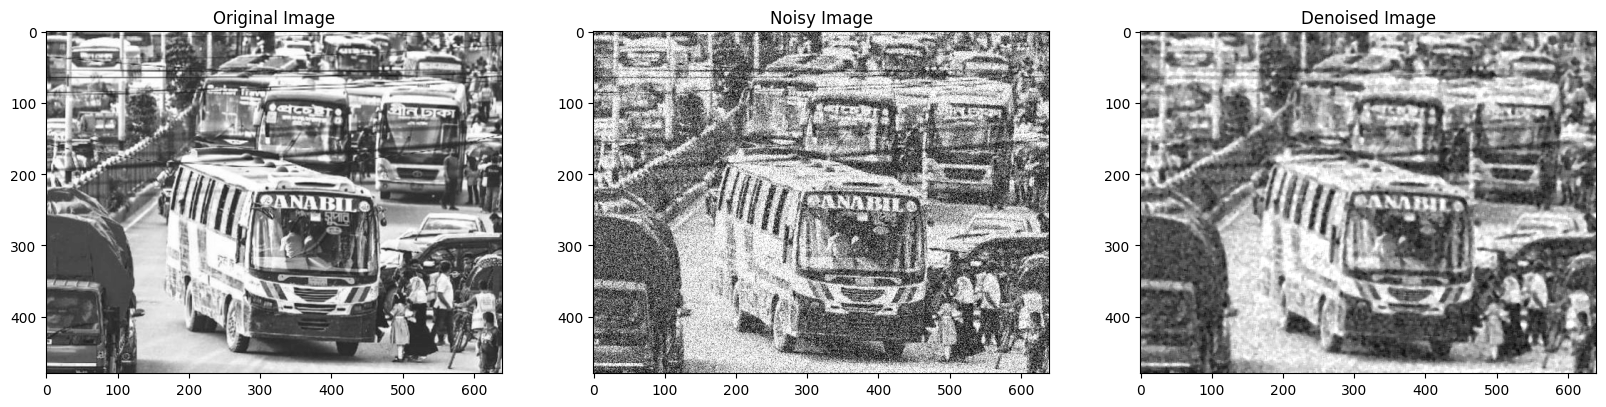

Noisy Image PSNR: 14.82, SSIM: 0.3673
Denoised Image PSNR: 20.88, SSIM: 0.6242


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def noise_gray(image_gray, sigma=0.2):
    # Ensure the image is in floating point format
    image_gray = img_as_float(image_gray)

    # Generate Gaussian noise
    gaussian_noise = np.random.normal(0, sigma, image_gray.shape)

    # Add the Gaussian noise to the image
    noisy_image = image_gray + gaussian_noise

    # Clip the values to stay between 0 and 1 and convert back to an appropriate image format
    noisy_image = np.clip(noisy_image, 0, 1)
    noisy_image = img_as_ubyte(noisy_image)

    return noisy_image

# Load the image
image = cv2.imread("/content/Traffic1.jpg")
# Convert to grayscale instead of RGB
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Convert the image array to float and normalize
img_array = image_to_normalized_array(image_gray)

noisy_image = noise_gray(image_gray, 0.2)

noisy_array = image_to_normalized_array(noisy_image)

# Apply median blur to denoise
denoised_array = cv2.medianBlur(noisy_array, 5)

# Display original, noisy, and denoised images side by side
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(img_array, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(noisy_array, cmap='gray')
plt.title('Noisy Image')

plt.subplot(1, 3, 3)
plt.imshow(denoised_array, cmap='gray')
plt.title('Denoised Image')

plt.show()

# Calculate PSNR and SSIM for noisy image
psnr_noisy, ssim_noisy = compare_images(img_array, noisy_array)

# Calculate PSNR and SSIM for denoised image
psnr_denoised, ssim_denoised = compare_images(img_array, denoised_array)

# Print the results
print(f"Noisy Image PSNR: {psnr_noisy:.2f}, SSIM: {ssim_noisy:.4f}")
print(f"Denoised Image PSNR: {psnr_denoised:.2f}, SSIM: {ssim_denoised:.4f}")